# 实践任务：
![](https://ai-studio-static-online.cdn.bcebos.com/ed6691c01b5141b1940645c613c15045fb20ae2643164862b9bad94787e2cbf2)

# 数据集介绍
训练数据集为华南理工大学实验室公布的数据集

数据中包含500张女生图片，分别由70人进行打分，最终取平均值即为该图片的打分情况。

我们在实践中将图片分值设定为1-5。

500张图片中，450张用于训练，50张用于验证。

![](https://ai-studio-static-online.cdn.bcebos.com/9d213946134f4fc4abba86a4f5c8de829cf6b62b9d074fceb6d22c2e1c8fb71e)

**任务：分析、利用给定的数据集，训练一个人脸颜值打分模型，给出模型在验证集上的准确率，并利用模型给 work/1.jpg 图片打分**


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import paddle
import matplotlib.pyplot as plt
from paddle.io import Dataset
import shutil

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [2]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3,224,224],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "src_path":"data/data18736/face_data_5.zip",       #原始数据集路径
    "target_path":"/home/aistudio/data/dataset",        #要解压的路径 
    "train_list_path": "./train.txt",              #train_data.txt路径
    "eval_list_path": "./eval.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "/home/aistudio/data/readme.json",   #readme.json路径
    "num_epochs": 50,                                    #训练轮数
    "train_batch_size": 16,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.01                                     #超参数学习率
    } ,
    "checkpoints": "/home/aistudio/work/checkpoints",          #保存的路径
    "skip_steps": 10,                                     #训练时输出日志的间隔
    "save_steps": 100,                                        #训练时保存模型参数的间隔
    "class_path":  "/home/aistudio/data_new",   #按分数分类的新的图片地址
    "augment_path":"/home/aistudio/augment"   #数据增强图片目录
}

In [3]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''
    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")

In [4]:
def get_data_new(target_path,train_list_path,eval_list_path,class_path):
    '''
    将图片按分数分类
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]

    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path) 
                for img_path2 in os.listdir(name_path):
                    if img_path2 =='.DS_Store':
                        continue
                    name_path2=os.path.join(name_path,img_path2)                     # 每张图片的原始路径

                    #将图片按分数分类
                    shutil.move(name_path2,class_path+"/"+img_path2[0]+"/"+img_path2)
    print("data_new已生成！")

In [5]:

'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
class_path=train_parameters['class_path']
augment_path=train_parameters['augment_path']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

#新建分类目录
#注意：只可运行一次
# os.mkdir(r'/home/aistudio/data_new')
# os.mkdir(r'/home/aistudio/data_new/1')
# os.mkdir(r'/home/aistudio/data_new/2')
# os.mkdir(r'/home/aistudio/data_new/3')
# os.mkdir(r'/home/aistudio/data_new/4')
# os.mkdir(r'/home/aistudio/data_new/5')

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#将图片按分数分类   
get_data_new(target_path,train_list_path,eval_list_path,class_path)


'''
参数更新
'''
train_parameters = {
    "input_size": [3,224,224],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "src_path":"data/data18736/face_data_5.zip",       #原始数据集路径
    "target_path":"/home/aistudio/data_new",        #更新
    "train_list_path": "./train.txt",              #train_data.txt路径
    "eval_list_path": "./eval.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "/home/aistudio/data/readme.json",   #readme.json路径
    "num_epochs": 40,                                    #训练轮数
    "train_batch_size": 16,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.01                                     #超参数学习率
    } ,
    "checkpoints": "/home/aistudio/work/checkpoints",          #保存的路径
    "skip_steps": 10,                                     #训练时输出日志的间隔
    "save_steps": 100,                                        #训练时保存模型参数的间隔
    "class_path":  "/home/aistudio/data_new",   #按分数分类的新的图片地址
    "augment_path":"/home/aistudio/augment"   #数据增强图片目录
}


data_new已生成！


In [6]:
def proc_img(src):
    for root, dirs, files in os.walk(src):
        if '__MACOSX' in root:continue
        for file in files:            
            src=os.path.join(root,file)
            img=Image.open(src)
            if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                    img.save(src)            


if __name__=='__main__':
    proc_img(r"/home/aistudio/data_new")

In [7]:
!pip install Augmentor

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import os, Augmentor
import shutil, glob

# 设置输出目录，控制不重复增强数据
if not os.path.exists(augment_path): 
    
    #os.walk()遍历指定目录下所有的文件夹
    for root, dirs, files in os.walk("/home/aistudio/data_new", topdown=False):
        print(root,dirs,files,'1')
        for name in dirs:
            path_ = os.path.join(root, name)

            # 过滤掉系统隐藏文件夹
            if '__MACOSX' in path_:continue
            print('数据增强：',os.path.join(root, name))
            print('image：',os.path.join(root, name))
            
            #创建 Augmentor.Pipeline 实例，并指定需要增强的图片所在目录，设置增强操作的参数，如旋转、缩放、扭曲等
            p = Augmentor.Pipeline(os.path.join(root, name),output_directory='output')
           
           #p.rotate()方法来设置旋转增强的概率（probability）
           #最大左旋角度（max_left_rotation）
           #最大右旋角度（max_right_rotation）
            p.rotate(probability=0.6, max_left_rotation=2, max_right_rotation=2)

            #p.zoom()方法用于设置缩放增强的概率（probability）
            #最小缩放因子（min_factor）
            #最大缩放因子（max_factor）
            p.zoom(probability=0.6, min_factor=0.9, max_factor=1.1)

            #p.random_distortion()方法用于设置扭曲增强的概率（probability）
            #网格高度（grid_height）、网格宽度（grid_width）和扭曲强度（magnitude）
            p.random_distortion(probability=0.4, grid_height=2, grid_width=2, magnitude=1)

            # 根据已有图片数量计算需要增强的数量
            count = 600 - len(glob.glob(pathname=path_+'/*.jpg'))

            #调用 sample() 方法进行样本扩增。
            p.sample(count, multi_threaded=False)
            p.process()

    print('将生成的图片拷贝到正确的目录')
    for root, dirs, files in os.walk("/home/aistudio/data_new", topdown=False):
        for name in files:
            path_ = os.path.join(root, name)
            if path_.rsplit('/',3)[2] == 'output':
                type_ = path_.rsplit('/',3)[1]
                dest_dir = os.path.join(augment_path ,type_) 
                if not os.path.exists(dest_dir):os.makedirs(dest_dir) 
                dest_path_ = os.path.join(augment_path ,type_, name) 
                shutil.move(path_, dest_path_)
    print('删除所有output目录')
    for root, dirs, files in os.walk("/home/aistudio/data_new", topdown=False):
        for name in dirs:
            if name == 'output':
                path_ = os.path.join(root, name)
                shutil.rmtree(path_)
    print('完成数据增强')

In [9]:
def get_data_list(target_path,train_list_path,eval_list_path,augment_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 10 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
            
            #----------------------------------数据增广-------------------------------

            aug_path=os.path.join(augment_path,class_dir)
            for img_path in os.listdir(aug_path):
                name_path = os.path.join(aug_path,img_path)                       # 每张图片的路径
                if class_sum % 10 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1 
                all_class_images += 1     
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    #print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print(readjson)
    print ('生成数据列表完成！')


In [10]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
augment_path=train_parameters['augment_path']

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#将图片按分数分类   
get_data_list(target_path,train_list_path,eval_list_path,augment_path)

{'all_class_name': '/home/aistudio/data_new', 'all_class_images': 3500, 'class_detail': [{'class_name': '2', 'class_label': 0, 'class_eval_images': 83, 'class_trainer_images': 744}, {'class_name': '5', 'class_label': 1, 'class_eval_images': 62, 'class_trainer_images': 556}, {'class_name': '3', 'class_label': 2, 'class_eval_images': 82, 'class_trainer_images': 734}, {'class_name': '1', 'class_label': 3, 'class_eval_images': 61, 'class_trainer_images': 541}, {'class_name': '4', 'class_label': 4, 'class_eval_images': 64, 'class_trainer_images': 573}]}
生成数据列表完成！


In [11]:
from paddle.vision import transforms as T

class Reader(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []
        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [12]:
train_dataset = Reader('/home/aistudio/',mode='train')
print(train_dataset.__len__())
eval_dataset = Reader('/home/aistudio/',mode='eval')
print(eval_dataset.__len__())
#训练数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)
#测试数据加载
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

3148
352


In [13]:
train_dataset.print_sample(400)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/aistudio/augment/3/3_original_3-146.jpg_19d26c5e-713f-4063-a634-8426a06e46bb.jpg 	标签值 2
3148
文件名 /home/aistudio/augment/4/4_original_4-199.jpg_9cdd0e8f-bea1-45d3-aec7-b9b8b5dd69f2.jpg 	标签值 4
352
(3, 224, 224)
(1,)


In [14]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()


In [15]:
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear,BatchNorm2D
import paddle.nn.functional as F

class MyCNN(paddle.nn.Layer):  #@save


    def __init__(self,train_mode):
        super(MyCNN, self).__init__()
        self.train_mode=train_mode
        self.conv1=Conv2D(in_channels=3, out_channels=32, kernel_size=3,stride=1,padding=2)
        self.pool1=MaxPool2D(kernel_size=2,stride=2)
        self.conv2=Conv2D(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=2)
        self.pool2=MaxPool2D(kernel_size=2,stride=2)
        self.conv3=Conv2D(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=2)
        self.pool3=MaxPool2D(kernel_size=2,stride=2)
        #dropout层
        self.dropout = paddle.nn.Dropout(0.5)
        self.dropout2 = paddle.nn.Dropout(0.2)
        self.bn1 = BatchNorm2D(32)#out_channels
        self.bn2 = BatchNorm2D(32)
        self.fc1 = paddle.fluid.dygraph.Linear(input_dim=32*29*29, output_dim=1024, act='relu')
        self.fc2 = paddle.fluid.dygraph.Linear(input_dim=1024, output_dim=512, act='relu')
        self.fc3 = paddle.fluid.dygraph.Linear(input_dim=512, output_dim=128, act='relu')
        self.fc4 = paddle.fluid.dygraph.Linear(input_dim=128, output_dim=64, act='relu')
        self.fc5 = paddle.fluid.dygraph.Linear(input_dim=64, output_dim=32, act='relu')
    def train_class(is_train):
        self.train_mode=is_train
    def forward(self, input):
        #print(Y[0].shape)
        Y = F.relu(self.bn1(self.conv1(input)))
        Y=self.pool1(Y)
        Y = self.bn2(self.conv2(Y))
        Y=self.pool2(Y)
        Y = self.bn2(self.conv3(Y))
        Y=self.pool3(Y)

        X=F.relu(self.bn1(self.conv1(input)))
        X=self.pool1(X)
        X = self.bn2(self.conv2(X))
        X=self.pool2(X)
        X = self.bn2(self.conv3(X))
        X=self.pool3(X)
        # if self.conv3:
        #     X = self.conv3(X)


        Y+=X
        Y=paddle.reshape(Y,shape=[-1,32*29*29])
        if(self.train_mode=="train"):
            Y=self.dropout2(Y)
        Y=self.fc1(Y)
        if(self.train_mode=="train"):
            Y=self.dropout(Y)
        Y=self.fc2(Y)
        if(self.train_mode=="train"):
            Y=self.dropout(Y)
        Y=self.fc3(Y)
        if(self.train_mode=="train"):
            Y=self.dropout(Y)
        Y=self.fc4(Y)
        if(self.train_mode=="train"):
            Y=self.dropout2(Y)
        Y=self.fc5(Y)
        return Y

W0513 10:31:56.375413   100 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0513 10:31:56.379365   100 device_context.cc:372] device: 0, cuDNN Version: 7.6.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


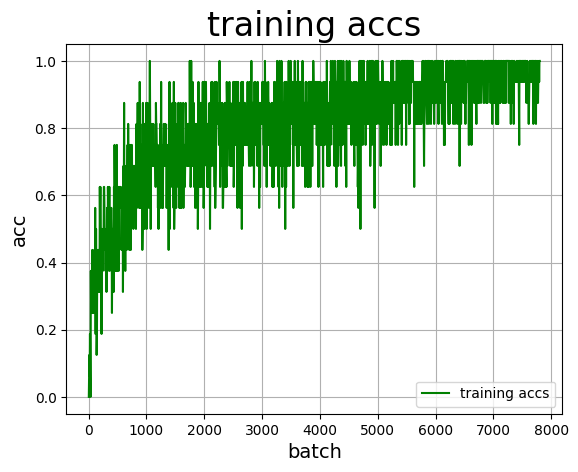

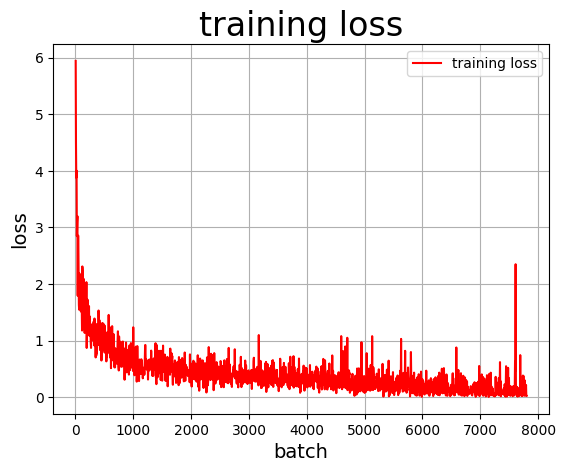

In [16]:
model=MyCNN("train") #模型实例化
model.train() #训练模式
cross_entropy = paddle.nn.CrossEntropyLoss()  
opt=paddle.optimizer.SGD(learning_rate=train_parameters['learning_strategy']['lr'], parameters=model.parameters())  #优化器设定，使用随机梯度下降算法的优化器

epochs_num=train_parameters['num_epochs'] #迭代次数
for pass_num in range(epochs_num):
    for batch_id,data in enumerate(train_loader()):
        image = data[0]
        label = data[1]
        
        # print(reshape(image).shape)
        
        predict=model(image) #数据传入model

        loss=cross_entropy(predict,label)
        acc=paddle.metric.accuracy(predict,label)#计算精度
        
        if batch_id!=0 and batch_id%5==0:
            Batch = Batch+5 
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
            
            print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))
        
        loss.backward() #进行反向传播求出梯度      
        opt.step()  #执行一次优化器并进行参数更新。
        opt.clear_grad()   #opt.clear_grad()来重置梯度

paddle.save(model.state_dict(),'MyCNN')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)


In [17]:
#模型评估
para_state_dict = paddle.load("MyCNN")
model = MyCNN("eval")
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #验证模式

accs = []

for batch_id,data in enumerate(eval_loader()):#测试集
    image=data[0]
    label=data[1]     
    predict=model(image)        
    acc=paddle.metric.accuracy(predict,label)
    accs.append(acc.numpy()[0])
    avg_acc = np.mean(accs)
print("当前模型在测试集上的准确率为:",avg_acc)


当前模型在测试集上的准确率为: 0.90909094


In [18]:
def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path)
    # print(img.mode)
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.ANTIALIAS)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255  # HWC to CHW 并像素归一化
    return img


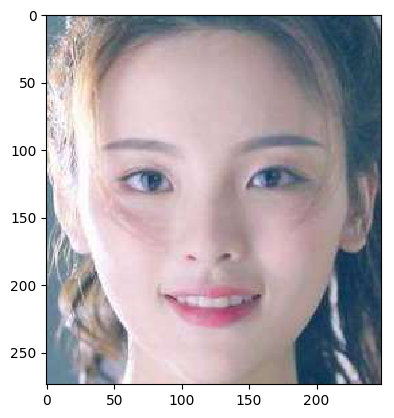

Score: 5


In [21]:
model__state_dict = paddle.load('MyCNN')
model= MyCNN("eval")
model.set_state_dict(model__state_dict) 
model.eval()


infer_path='work/1.jpg'
infer_img = Image.open(infer_path)
plt.imshow(infer_img)          #根据数组绘制图像
plt.show()                     #显示图像


#对预测图片进行预处理
infer_img = load_image(infer_path)

# print(type(infer_img))
infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,50,50)
infer_img = paddle.to_tensor(infer_img)
results = model(infer_img)
print("Score: {:d}".format(paddle.argmax(results).numpy()[0] + 1))



